In [153]:
import os
import os.path as op
import glob
import numpy as np
import multiprocessing
import pandas as pd
import nibabel as nib
import scipy
import matplotlib
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests, _ecdf as ecdf, fdrcorrection as fdrcorrection0, fdrcorrection_twostage
%matplotlib inline

In [19]:
#preliminary housekeeping
home_dir = '/data/home/iballard/mag/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
runs = map(str,range(1,5))

In [493]:
smoothing = 'smoothed'
regspace = 'epi'

exp = 'mag-SVLL'
contrast = 'high_minus_low_SV_LL'

rois = ['_amfg',
        '_pmfg',
        '_fpc',
        '_ifg',
        '_psfs',
        '_ifs',
       '_ains',
       'h.vmpfc']

In [495]:
df = pd.DataFrame(columns=('sub','contrast','mask_vox','hemi','label','value'))

for sub in subs:
    cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/' + regspace + \
        '/' + smoothing + '/' + contrast + '/cope1.nii.gz'
    cope = nib.load(cope).get_data()
    
    masks = glob.glob(home_dir + '/data/' + sub + '/masks/*.*nii.gz')
    masks = [m for m in masks if any(substring in m for substring in rois)]

    for m in masks:
        if len(m.split('/')[-1].split('.'))==4:
            hemi = m.split('/')[-1].split('.')[0]
            label = m.split('/')[-1].split('.')[1]
        else:
            hemi = 'na'
            label = m.split('/')[-1].split('.')[0]

        m = nib.load(m).get_data().astype(bool)
        num_voxels = m.sum()
        func_masked = cope[m]
        row = pd.DataFrame([dict(sub = sub, 
                                 contrast =contrast, 
                                 mask_vox = num_voxels, 
                                 hemi = hemi,
                                 label = label, 
                                 value = func_masked.mean()), ])
        df = df.append(row, ignore_index = True)

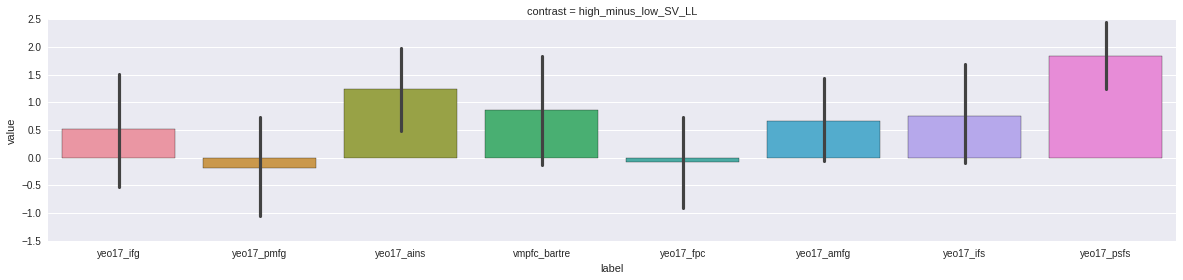

In [496]:
sns.factorplot(x='label', y='value', col='contrast', 
               aspect=4, kind='bar', col_wrap=4,
               ci=68, 
               units='sub', data=df)
# plt.savefig('/home/iballard/Dropbox/mag_figs/' + contrast + '.png')

In [497]:
df.to_csv('/home/iballard/Dropbox/Magnitude_fMRI/roi_analysis/' + exp  + '_' + contrast + '.csv',
          index = False)

In [498]:
results_df =pd.DataFrame(columns=('contrast','label','p_unc'))
for roi in set(df['label']):
    vals = df.ix[df['label'] == roi,'value'].values
    t,p = scipy.stats.wilcoxon(vals)
    row = pd.DataFrame([dict(contrast = contrast, 
                             label = roi,
                            p_unc = p), ])
    results_df = results_df.append(row, ignore_index = True)
sig,pcorr = fdrcorrection0(results_df['p_unc'],.05)
results_df['p_corr'] = pcorr
results_df['sig'] = sig

print results_df

               contrast         label     p_unc    p_corr    sig
0  high_minus_low_SV_LL     yeo17_ifg  0.370518  0.592829  False
1  high_minus_low_SV_LL     yeo17_fpc  0.862796  0.862796  False
2  high_minus_low_SV_LL    yeo17_amfg  0.519489  0.692652  False
3  high_minus_low_SV_LL    yeo17_ains  0.039582  0.158328  False
4  high_minus_low_SV_LL     yeo17_ifs  0.197653  0.477360  False
5  high_minus_low_SV_LL    yeo17_pmfg  0.671431  0.767349  False
6  high_minus_low_SV_LL  vmpfc_bartre  0.238680  0.477360  False
7  high_minus_low_SV_LL    yeo17_psfs  0.000384  0.003075   True


In [467]:
results_df =pd.DataFrame(columns=('contrast','label','p_unc'))
for roi in set(df['label']):
    vals = df.ix[df['label'] == roi,'value'].values
    t,p = scipy.stats.wilcoxon(vals)
    row = pd.DataFrame([dict(contrast = contrast, 
                             label = roi,
                            p_unc = p), ])
    results_df = results_df.append(row, ignore_index = True)
sig,pcorr = fdrcorrection0(results_df['p_unc'],.05)
results_df['p_corr'] = pcorr
results_df['sig'] = sig

print results_df

  contrast         label     p_unc    p_corr    sig
0  SV_diff     yeo17_ifg  0.556974  0.742632  False
1  SV_diff     yeo17_fpc  0.000920  0.004291   True
2  SV_diff    yeo17_amfg  0.052861  0.084578  False
3  SV_diff    yeo17_ains  0.041593  0.083186  False
4  SV_diff     yeo17_ifs  0.001456  0.004291   True
5  SV_diff    yeo17_pmfg  0.001609  0.004291   True
6  SV_diff  vmpfc_bartre  0.936426  0.936426  False
7  SV_diff    yeo17_psfs  0.936426  0.936426  False


In [426]:
sub = 'asu8'
cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/' + regspace + \
    '/' + smoothing + '/' + 'mean_SV' + '/cope1.nii.gz'
cope1 = nib.load(cope).get_data()

In [427]:
sub = 'asu8'
cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/' + regspace + \
    '/' + smoothing + '/' + 'max_SV' + '/cope1.nii.gz'
cope2 = nib.load(cope).get_data()

In [435]:
df

,contrast,hemi,label,mask_vox,sub,value
0,max_SV,lh,yeo17_ifg,1807,asu4,1.427625
1,max_SV,lh,yeo17_pmfg,509,asu4,-5.106286
2,max_SV,lh,yeo17_ains,706,asu4,2.467940
3,max_SV,lh,vmpfc_bartre,90,asu4,2.057218
4,max_SV,rh,yeo17_fpc,1738,asu4,-1.190106
5,max_SV,rh,yeo17_amfg,1560,asu4,-2.556689
6,max_SV,rh,yeo17_ains,1056,asu4,-0.189213
7,max_SV,lh,yeo17_amfg,1181,asu4,-3.913633
8,max_SV,rh,yeo17_ifs,1429,asu4,-7.509581
9,max_SV,lh,yeo17_ifs,1407,asu4,2.253505


In [439]:
df

,contrast,hemi,label,mask_vox,sub,value
0,mean_SV,lh,yeo17_ifg,1807,asu4,2.855250
1,mean_SV,lh,yeo17_pmfg,509,asu4,-10.212572
2,mean_SV,lh,yeo17_ains,706,asu4,4.935880
3,mean_SV,lh,vmpfc_bartre,90,asu4,4.114437
4,mean_SV,rh,yeo17_fpc,1738,asu4,-2.380213
5,mean_SV,rh,yeo17_amfg,1560,asu4,-5.113379
6,mean_SV,rh,yeo17_ains,1056,asu4,-0.378425
7,mean_SV,lh,yeo17_amfg,1181,asu4,-7.827267
8,mean_SV,rh,yeo17_ifs,1429,asu4,-15.019162
9,mean_SV,lh,yeo17_ifs,1407,asu4,4.507010
